<a href="https://colab.research.google.com/github/byunsy/brain-mri-segmentation/blob/main/Brain_MRI_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain MRI Segmentation


## 01. Import Necessary Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

In [2]:
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

In [3]:
import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

## 02. Attain Dataset from Kaggle

In [4]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [6]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

100% 712M/714M [00:07<00:00, 105MB/s] 
100% 714M/714M [00:07<00:00, 96.0MB/s]


In [ ]:
!unzip /content/lgg-mri-segmentation.zip

## 03. Understanding the Dataset

In [10]:
base_dir = "/content/kaggle_3m"

In [11]:
!rm -r /content/lgg-mri-segmentation

In [12]:
data_map = []

for sub_dir_path in glob.glob(os.path.join(base_dir, "*")):

    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])

    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/content/kaggle_3m/README.md'
[Errno 20] Not a directory: '/content/kaggle_3m/data.csv'


In [13]:
data_map[:20]

['TCGA_DU_8167_19970402',
 '/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_14.tif',
 'TCGA_DU_8167_19970402',
 '/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_24_mask.tif',
 'TCGA_DU_8167_19970402',
 '/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_25_mask.tif',
 'TCGA_DU_8167_19970402',
 '/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_24.tif',
 'TCGA_DU_8167_19970402',
 '/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_4.tif',
 'TCGA_DU_8167_19970402',
 '/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_9.tif',
 'TCGA_DU_8167_19970402',
 '/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_1_mask.tif',
 'TCGA_DU_8167_19970402',
 '/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_13_mask.tif',
 'TCGA_DU_8167_19970402',
 '/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_12.tif',
 'TCGA_DU_8167_19970402',
 '/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_1

In [14]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df

,patient_id,path
0,TCGA_DU_8167_19970402,/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_...
1,TCGA_DU_8167_19970402,/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_...
2,TCGA_DU_8167_19970402,/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_...
3,TCGA_DU_8167_19970402,/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_...
4,TCGA_DU_8167_19970402,/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_...
...,...,...
7853,TCGA_HT_7605_19950916,/content/kaggle_3m/TCGA_HT_7605_19950916/TCGA_...
7854,TCGA_HT_7605_19950916,/content/kaggle_3m/TCGA_HT_7605_19950916/TCGA_...
7855,TCGA_HT_7605_19950916,/content/kaggle_3m/TCGA_HT_7605_19950916/TCGA_...
7856,TCGA_HT_7605_19950916,/content/kaggle_3m/TCGA_HT_7605_19950916/TCGA_...


In [15]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

In [16]:
print(len(df_imgs))
print(len(df_masks))

3929
3929


In [17]:
data_map[:5]

['TCGA_DU_8167_19970402',
 '/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_14.tif',
 'TCGA_DU_8167_19970402',
 '/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_24_mask.tif',
 'TCGA_DU_8167_19970402']

In [18]:
len("/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_")

63

In [19]:
# File path line length images for later sorting
BASE_LEN = 63 
END_IMG_LEN = 4 
END_MASK_LEN = 9

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

In [20]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks})

# Determines whether the mask has pixels in them
# - some will be blank black images
# - while some will have white pixels
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    

brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_DU_8167_19970402,/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_...,/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_...,0
1,TCGA_DU_8167_19970402,/content/kaggle_3m/TCGA_DU_7304_19930325/TCGA_...,/content/kaggle_3m/TCGA_DU_7304_19930325/TCGA_...,0
2,TCGA_DU_8167_19970402,/content/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_...,/content/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_...,0
3,TCGA_DU_8167_19970402,/content/kaggle_3m/TCGA_HT_8111_19980330/TCGA_...,/content/kaggle_3m/TCGA_HT_8111_19980330/TCGA_...,0
4,TCGA_DU_8167_19970402,/content/kaggle_3m/TCGA_DU_7299_19910417/TCGA_...,/content/kaggle_3m/TCGA_DU_7299_19910417/TCGA_...,0
...,...,...,...,...
3924,TCGA_HT_7605_19950916,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3925,TCGA_HT_7605_19950916,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0
3926,TCGA_HT_7605_19950916,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3927,TCGA_HT_7605_19950916,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0


## 04. Data Exploration and Visualization

In [21]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

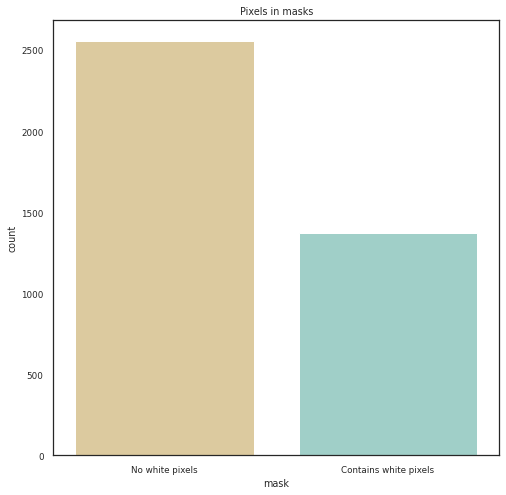

In [22]:
sns.set(rc={ 'figure.figsize':(8.0, 8.0) }, style='white', font_scale=0.8)
sns.countplot(x='mask', data=brain_df, palette='BrBG')

plt.title('Pixels in masks')
plt.xticks(ticks=[0, 1], labels=['No white pixels', 'Contains white pixels'])

plt.show()

Text(0.5, 1.0, 'MRI Scan')

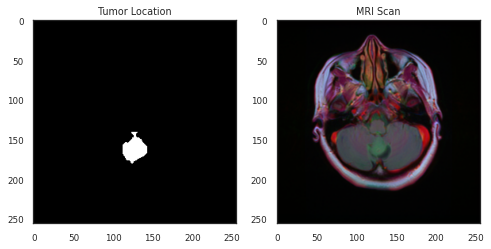

In [23]:
# Traverse and select the first mri scan that has a valid mask 
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

# Display 
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));
plt.title('MRI Scan')

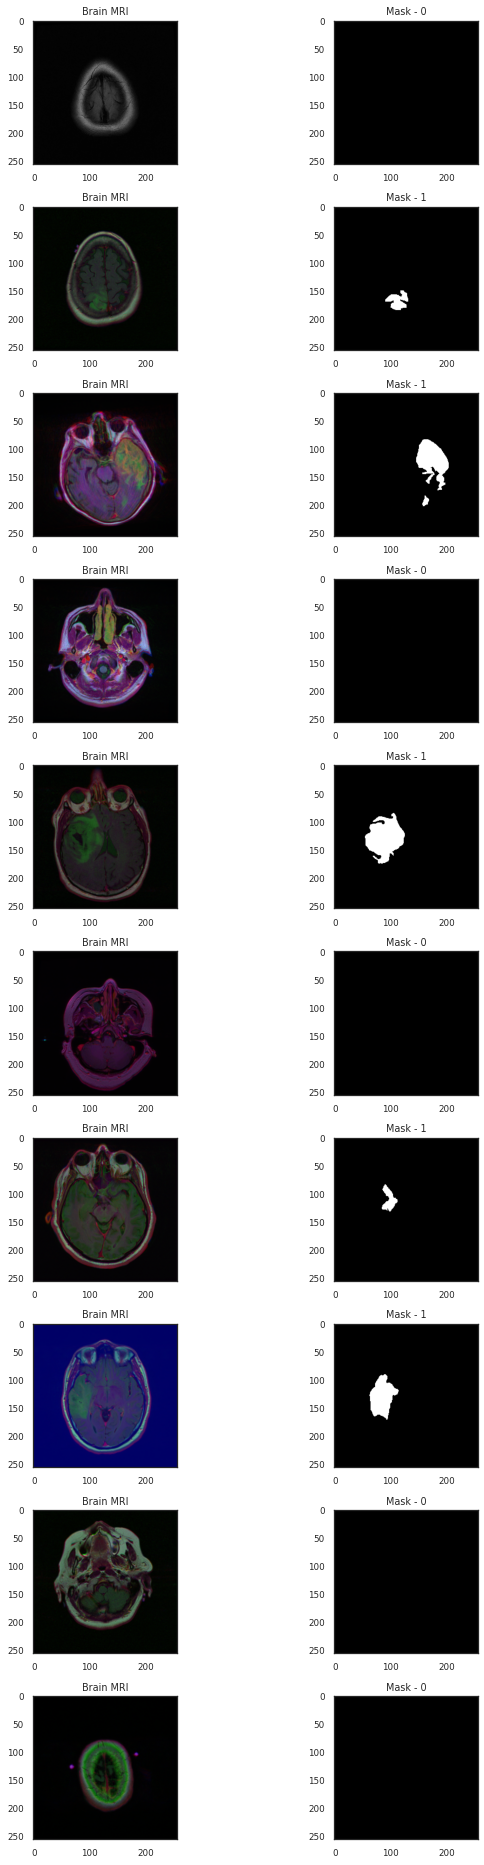

In [29]:
# Visualization of Brain MRI scans and Mask images
# - randomly select 10 pairs of mri-scan and masks

# Create 10x2 plot figure (10 rows x 2 cols)
fig, axs = plt.subplots(10,2, figsize=(10,26))

for x in range(10):
  i = random.randint(0, len(brain_df)) # select a random index

  axs[x][0].title.set_text("Brain MRI") # MRI title
  axs[x][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 

  axs[x][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # Mask title (0 or 1)
  axs[x][1].imshow(cv2.imread(brain_df.mask_path[i])) # show corresponding mask

fig.tight_layout()

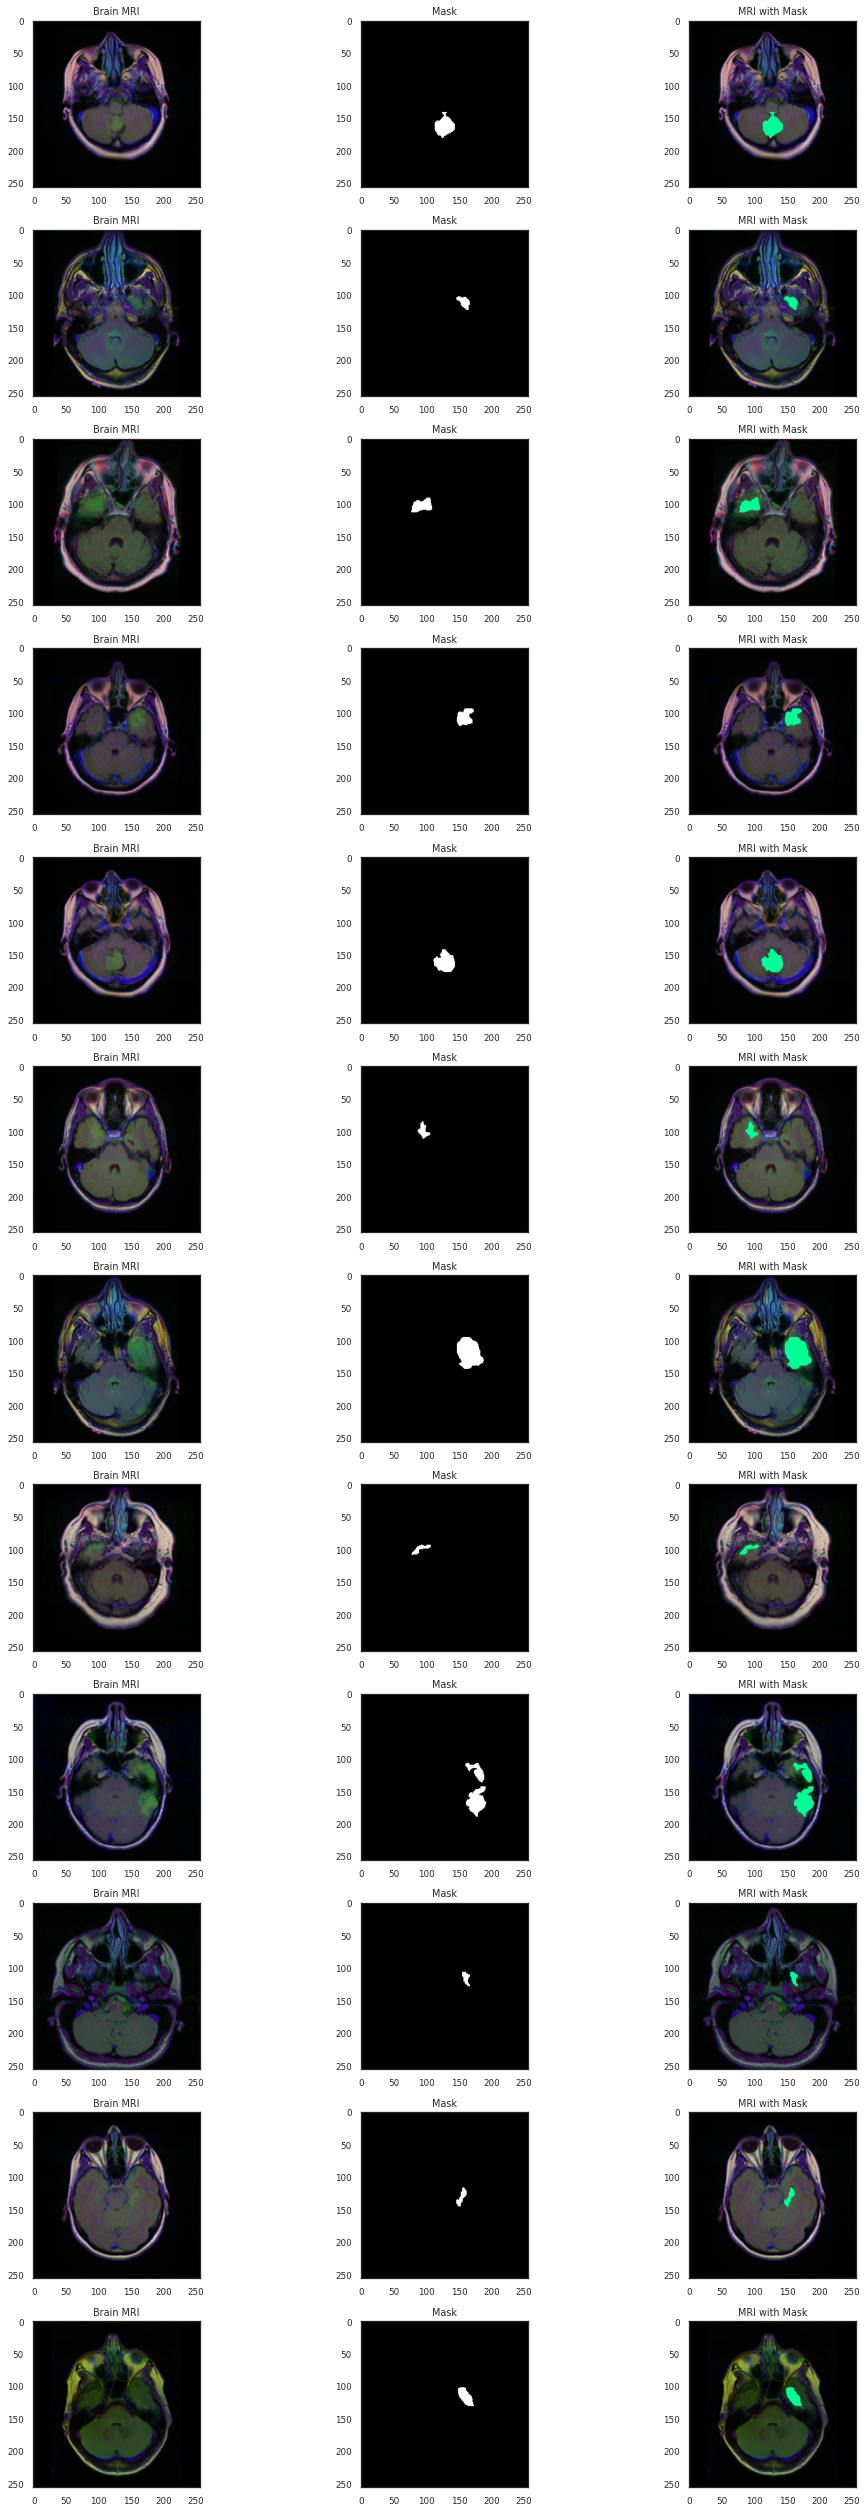

In [48]:
fig,axs = plt.subplots(12,3, figsize=(15,35))

count = 0
for i, mask in enumerate(brain_df['mask']):
    if (mask==1):
        
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (0,255,150)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        
        count +=1

    if (count==12):
        break
        
fig.tight_layout()

## 05. Data Preparation

In [49]:
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_DU_8167_19970402,/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_...,/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_...,0
1,TCGA_DU_8167_19970402,/content/kaggle_3m/TCGA_DU_7304_19930325/TCGA_...,/content/kaggle_3m/TCGA_DU_7304_19930325/TCGA_...,0
2,TCGA_DU_8167_19970402,/content/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_...,/content/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_...,0
3,TCGA_DU_8167_19970402,/content/kaggle_3m/TCGA_HT_8111_19980330/TCGA_...,/content/kaggle_3m/TCGA_HT_8111_19980330/TCGA_...,0
4,TCGA_DU_8167_19970402,/content/kaggle_3m/TCGA_DU_7299_19910417/TCGA_...,/content/kaggle_3m/TCGA_DU_7299_19910417/TCGA_...,0
...,...,...,...,...
3924,TCGA_HT_7605_19950916,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3925,TCGA_HT_7605_19950916,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0
3926,TCGA_HT_7605_19950916,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3927,TCGA_HT_7605_19950916,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0


In [51]:
brain_df_src = brain_df.drop(columns=['patient_id'])
brain_df_src

,image_path,mask_path,mask
0,/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_...,/content/kaggle_3m/TCGA_DU_8167_19970402/TCGA_...,0
1,/content/kaggle_3m/TCGA_DU_7304_19930325/TCGA_...,/content/kaggle_3m/TCGA_DU_7304_19930325/TCGA_...,0
2,/content/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_...,/content/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_...,0
3,/content/kaggle_3m/TCGA_HT_8111_19980330/TCGA_...,/content/kaggle_3m/TCGA_HT_8111_19980330/TCGA_...,0
4,/content/kaggle_3m/TCGA_DU_7299_19910417/TCGA_...,/content/kaggle_3m/TCGA_DU_7299_19910417/TCGA_...,0
...,...,...,...
3924,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3925,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0
3926,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3927,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0


In [56]:
brain_df_src.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 92.2+ KB


In [59]:
brain_df_src['mask'] = brain_df_src['mask'].astype('string')
brain_df_src.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   string
dtypes: object(2), string(1)
memory usage: 92.2+ KB


In [53]:
BATCH_SIZE = 16
IMG_SHAPE = 256

In [60]:
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator

# First split into train and test sets at 80:20 ratio
# Second split into train validation at 75:25 ratio
# - results in 60:20:20 ratio (train, val, test)
train, test = train_test_split(brain_df_src, test_size=0.2, random_state=1)
train, val = train_test_split(train, test_size=0.25, random_state=1)

# TRAIN
image_gen_train = ImageDataGenerator(rescale=1./255.)
train_data_gen = image_gen_train.flow_from_dataframe(
    train,
    directory='./',
    x_col='image_path',
    y_col='mask',
    # subset='training',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE)
)

# VALID
image_gen_val = ImageDataGenerator(rescale=1./255.)
val_data_gen = image_gen_val.flow_from_dataframe(
    val,
    directory='./',
    x_col='image_path',
    y_col='mask',
    # subset='validation',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE)
)

# TEST
image_gen_test = ImageDataGenerator(rescale=1./255.)
test_data_gen = image_gen_test.flow_from_dataframe(
    test,
    directory='./',
    x_col='image_path',
    y_col='mask',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    target_size=(IMG_SHAPE,IMG_SHAPE)
)

Found 2357 validated image filenames belonging to 2 classes.
Found 786 validated image filenames belonging to 2 classes.
Found 786 validated image filenames belonging to 2 classes.


In [61]:
# This function will plot images in the form of a grid with 1 row and 5 columns 
# where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

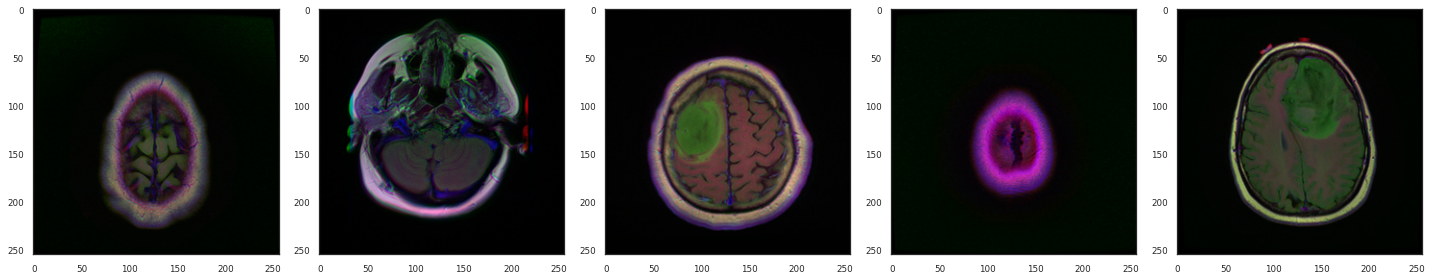

In [68]:
augmented_images = [train_data_gen[0][0][i] for i in range(5)]
plotImages(augmented_images)